# Import Required Libraries

In [1]:
# Basic Stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

# For Model Training
import math
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt 
import pmdarima
from pmdarima import auto_arima
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

Order of content:
1. EDA
2. Data Pre Processing
3. Check stationarity
4. ARIMA
5. SARIMAX
6. Exponential Smoothing
7. Ensemble Learning (ARIMA + SARIMAX)

# 1. EDA

In [2]:
raw = pd.read_excel('../datasets/anonymised_orders_original.xlsx')
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22976 entries, 0 to 22975
Data columns (total 81 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Name                         22976 non-null  object 
 1   Email                        14869 non-null  object 
 2   Financial Status             10942 non-null  object 
 3   Paid at                      10831 non-null  object 
 4   Fulfillment Status           10942 non-null  object 
 5   Fulfilled at                 10801 non-null  object 
 6   Accepts Marketing            10942 non-null  object 
 7   Currency                     10942 non-null  object 
 8   Subtotal                     10942 non-null  float64
 9   Shipping                     10942 non-null  float64
 10  Taxes                        10942 non-null  float64
 11  Total                        10942 non-null  float64
 12  Discount Code                1414 non-null   object 
 13  Discount Amount 

In [3]:
pd.set_option('display.max_columns', None)
raw.head(3)

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Outstanding Balance,Employee,Location,Device ID,Id,Tags,Risk Level,Source,Lineitem discount,Tax 1 Name,Tax 1 Value,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References,Unnamed: 79,Unnamed: 80
0,#3200,893696139@yopmail.com,paid,2022-04-29 18:29:50 +0800,fulfilled,2022-06-17 13:40:16 +0800,yes,SGD,143.0,0.0,0.0,143.0,NaN,0.0,NaN,2022-04-29 18:29:49 +0800,1,Arzuaga blanco,49.0,NaN,NaN,True,True,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,c27103567773794.1,0.0,NaN,0.0,NaN,120 Tembeling Rd,2.0,4.443627e+12,NaN,Low,pos,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-1519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,#3200,893696139@yopmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-04-29 18:29:49 +0800,1,Arzuaga reserva,94.0,NaN,NaN,True,True,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,#3070,893696139@yopmail.com,paid,2022-04-22 18:09:00 +0800,fulfilled,2022-04-22 18:08:59 +0800,no,SGD,175.0,0.0,0.0,175.0,NaN,0.0,NaN,2022-04-22 18:08:59 +0800,1,Eclisse,51.0,NaN,NaN,True,True,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,custom,c27048027226210.1,0.0,NaN,0.0,NaN,120 Tembeling Rd,2.0,4.430591e+12,NaN,Low,pos,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2-1429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
raw[raw['Name'] == 36047].head(3)

,Name,Email,Financial Status,Paid at,Fulfillment Status,Fulfilled at,Accepts Marketing,Currency,Subtotal,Shipping,Taxes,Total,Discount Code,Discount Amount,Shipping Method,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem compare at price,Lineitem sku,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Billing Name,Billing Street,Billing Address1,Billing Address2,Billing Company,Billing City,Billing Zip,Billing Province,Billing Country,Billing Phone,Shipping Name,Shipping Street,Shipping Address1,Shipping Address2,Shipping Company,Shipping City,Shipping Zip,Shipping Province,Shipping Country,Shipping Phone,Notes,Note Attributes,Cancelled at,Payment Method,Payment Reference,Refunded Amount,Vendor,Outstanding Balance,Employee,Location,Device ID,Id,Tags,Risk Level,Source,Lineitem discount,Tax 1 Name,Tax 1 Value,Tax 2 Name,Tax 2 Value,Tax 3 Name,Tax 3 Value,Tax 4 Name,Tax 4 Value,Tax 5 Name,Tax 5 Value,Phone,Receipt Number,Duties,Billing Province Name,Shipping Province Name,Payment ID,Payment Terms Name,Next Payment Due At,Payment References,Unnamed: 79,Unnamed: 80
8114,36047,635422575@yopmail.com,paid,2022-01-22 05:54:17 +0800,fulfilled,2022-01-22 05:54:15 +0800,no,SGD,2813.0,0.0,0.0,2813.0,NaN,0.0,Free Shipping,2022-01-22 05:54:13 +0800,1,Zenato Amarone Riserva 'Sergio Zenato’ 2015,178.0,NaN,NaN,True,True,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36047.1,0.0,Boundby Wine,-1938.46,NaN,NaN,NaN,4.256488e+12,Cheese Charcuterie Board,Low,3139779,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8115,36047,635422575@yopmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 05:54:13 +0800,1,Giacomo Montresor Amarone Della Valpolicella (...,68.0,NaN,NaN,True,True,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8116,36047,635422575@yopmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-01-22 05:54:13 +0800,1,Cesari Amarone Della Valpolicella Classico 2015,92.0,NaN,NaN,True,True,fulfilled,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Boundby Wine,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Understanding key columns
- We learn that 'Name' refers to a unique id assigned to each customer
- Looking at the 'Created at' we see that each row corresponds to each item bought, regardless of whether it's bought in the same transaction or not
- For example, if a customer buy 5 wines in one transaction, we will have 5 different rows
- The 'Total' is the total price of every items bought in that transaction, but only appears in the first row
- Since the information of items bought in a transaction can be derived from matching 'Name' and 'Created at', we can ignore 'Total' and only look at each item's price at 'Lineitem price'

In [28]:
print(raw.columns)

Index(['Name', 'Email', 'Financial Status', 'Paid at', 'Fulfillment Status',
       'Fulfilled at', 'Accepts Marketing', 'Currency', 'Subtotal', 'Shipping',
       'Taxes', 'Total', 'Discount Code', 'Discount Amount', 'Shipping Method',
       'Created at', 'Lineitem quantity', 'Lineitem name', 'Lineitem price',
       'Lineitem compare at price', 'Lineitem sku',
       'Lineitem requires shipping', 'Lineitem taxable',
       'Lineitem fulfillment status', 'Billing Name', 'Billing Street',
       'Billing Address1', 'Billing Address2', 'Billing Company',
       'Billing City', 'Billing Zip', 'Billing Province', 'Billing Country',
       'Billing Phone', 'Shipping Name', 'Shipping Street',
       'Shipping Address1', 'Shipping Address2', 'Shipping Company',
       'Shipping City', 'Shipping Zip', 'Shipping Province',
       'Shipping Country', 'Shipping Phone', 'Notes', 'Note Attributes',
       'Cancelled at', 'Payment Method', 'Payment Reference',
       'Refunded Amount', 'Vendor', '

#### Now, let's drop columns with null values (except sku)

In [5]:
raw_dropna = raw.dropna(axis=1)
raw_dropna['sku'] = raw['Lineitem sku']
raw_dropna.head(2)

/var/folders/j9/hl0rz3wj6yb5zwjtn6qjs8bh0000gn/T/ipykernel_53807/4102796887.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dropna['sku'] = raw['Lineitem sku']


,Name,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem requires shipping,Lineitem taxable,Lineitem fulfillment status,Lineitem discount,sku
0,#3200,2022-04-29 18:29:49 +0800,1,Arzuaga blanco,49.0,True,True,fulfilled,0.0,NaN
1,#3200,2022-04-29 18:29:49 +0800,1,Arzuaga reserva,94.0,True,True,fulfilled,0.0,NaN


#### We can drop a few columns that will not contribute to demand prediction

In [6]:
to_drop = ['Lineitem requires shipping', 'Lineitem taxable', 'Lineitem fulfillment status']

raw_dropna1 = raw_dropna.drop(columns=to_drop)
raw_dropna1.head(2)

,Name,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem discount,sku
0,#3200,2022-04-29 18:29:49 +0800,1,Arzuaga blanco,49.0,0.0,NaN
1,#3200,2022-04-29 18:29:49 +0800,1,Arzuaga reserva,94.0,0.0,NaN


### EDA on Price
Let's scrutinise the price first - look at the spread of Price column

In [9]:
# Calculate the maximum, minimum, and median prices
max_price = raw_dropna1['Lineitem price'].max()
min_price = raw_dropna1['Lineitem price'].min()
median_price = raw_dropna1['Lineitem price'].median()
mean_price = raw_dropna1['Lineitem price'].mean()

# Print the results
print("Maximum Price:", max_price)
print("Minimum Price:", min_price)
print("Median Price:", median_price)
print("Mean Price:", round(mean_price,2))

Maximum Price: 2400.0
Minimum Price: 0.0
Median Price: 56.0
Mean Price: 58.94


In [10]:
pd.set_option('display.max_rows', None)

raw_dropna1[raw_dropna1['Lineitem price'] > 500].head(5)

,Name,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem discount,sku
87,#9594,2023-03-28 12:46:21 +0800,1,WIne Tasting Workshop,980.0,0.0,NaN
837,#7170,2022-12-06 22:50:38 +0800,1,Food Tasting (7 Pax),672.1,0.0,NaN
3019,#7739,2022-12-31 12:30:00 +0800,1,French Wine Workshop (03 & 04 Jan),1686.3,0.0,NaN
3020,#7739,2022-12-31 12:30:00 +0800,1,Wine Specialist Engagement (03 & 04 Jan),2400.0,0.0,NaN
3022,#6907,2022-11-22 09:41:35 +0800,1,Chanel Workshop (23 November 2022),806.0,0.0,NaN


### We see there's a lot of non-alcohol listed here

In [11]:
pd.set_option('display.max_rows', None)

raw_dropna1[raw_dropna1['Lineitem price'] < 10].head(5)

,Name,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem discount,sku
149,#8024,2023-01-15 16:07:59 +0800,1,Falwasser Crackers - Charcoal,9.5,0.0,NaN
150,#8024,2023-01-15 16:07:59 +0800,1,Falwasser Crackers - Natural,9.5,0.0,NaN
158,#5981,2022-10-06 17:13:48 +0800,1,Tyrells Chips - Pesto parmesan,5.3,0.0,NaN
161,#5903,2022-10-01 15:14:39 +0800,3,Ollie,8.0,0.0,NaN
190,11691,2023-07-16 16:38:25 +0800,2,Jukes - Sparkling Pinot Noir (Single Can),7.0,0.0,NaN


### Same here with those at the bottom end spectrum of the price

As such, we had to manually throw away these items

In [18]:
item_names_to_exclude = [
    'tasting', 'workshop', 'event', 'bundle', 'subscription', 
    'venue booking', 'engagement', 'jancis', 'zalto', 
    'outstanding balance', 'cheese', 'wine addict', 'wine virgin', 'wine nut', 
    'shopee', 'crackers', 'chip', 'pretzel', 'chili', 'nuts',
    'harvest box', 'coconut water', 'tonic water', 'lavender water', 'sparkling water', 
    'dash water', 'fiji water', 'all shook up', 'mezete', 'dinner', 
    'catering', 'service', 'barbecue', 'barbeque', 'charcuterie', 'platter',
    'decanter', 'case of', 'networking', 'shiok', 'cappuccino', 'latte', 
    'soda', 'sparkling juice', 'hamper', 'zieher', 'gift card', 'gift set',
    'hunny bunny', 'sampl', 'misc', 'combo', 'pax', 'pizza', 'bbq', 
    'glassware', 'snowboard', 'chocolate', 'gift wrap', 'bottled water', 
    "riedel 'vinum'", "riedel 'extreme'", 'riedel winewings',
    'wine ambassador series', 'wine stoppers', 'pasta', 'tomato sauce', 
    'gift message', 'olive oil', 'magazine'
]

In [19]:
pd.reset_option('display.max_rows')

raw_dropna2 = raw_dropna1[~raw_dropna1['Lineitem name'].str.lower().str.contains('|'.join(item_names_to_exclude))]
raw_dropna2.reset_index(drop=True, inplace=True)
raw_dropna2

,Name,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem discount,sku
0,#3200,2022-04-29 18:29:49 +0800,1,Arzuaga blanco,49.0,0.0,NaN
1,#3200,2022-04-29 18:29:49 +0800,1,Arzuaga reserva,94.0,0.0,NaN
2,#3070,2022-04-22 18:08:59 +0800,1,Eclisse,51.0,0.0,NaN
3,#3070,2022-04-22 18:08:59 +0800,2,Refosco,62.0,0.0,NaN
4,11752,2023-07-20 17:00:28 +0800,1,Ziereisen Blauer Spatburgunder 2017,50.0,0.0,NaN
...,...,...,...,...,...,...,...
18635,#2303,2022-02-23 20:23:34 +0800,1,The Prisoner Saldo Zinfandel NV,82.0,0.0,NaN
18636,#2303,2022-02-23 20:23:34 +0800,1,Louis Tête Coteaux du Lyonnais Antique Bellum ...,34.0,0.0,NaN
18637,#2303,2022-02-23 20:23:34 +0800,1,Mastrojanni Rosso di Montalcino 2018,77.0,0.0,NaN
18638,#2303,2022-02-23 20:23:34 +0800,1,Tokumasamune Tokubetsu Junmai Yamahai - 720 ML,82.0,0.0,NaN


### EDA on Price (Reprise)
Now let's see the distribution of our cleaned up prices again

Maximum Price: 599.0
Minimum Price: 0.0
Median Price: 59.0


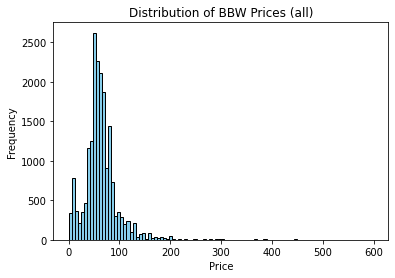

In [16]:
max_price = raw_dropna2['Lineitem price'].max()
min_price = raw_dropna2['Lineitem price'].min()
median_price = raw_dropna2['Lineitem price'].median()

print("Maximum Price:", max_price)
print("Minimum Price:", min_price)
print("Median Price:", median_price)

plt.hist(raw_dropna2['Lineitem price'], bins=100, range=(min_price, max_price), color='skyblue', edgecolor='black')
plt.title('Distribution of BBW Prices (all)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

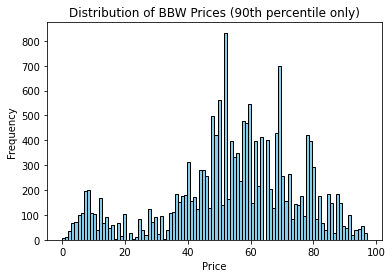

In [17]:
ninety_percentile = np.percentile(raw_dropna2['Lineitem price'], 90)

# plt.figure(figsize=(10, 6))
plt.hist(raw_dropna2['Lineitem price'], bins=100, range=(min_price, ninety_percentile), color='skyblue', edgecolor='black')
plt.title('Distribution of BBW Prices (90th percentile only)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 2. Pre-Processing
- before we can throw data into the models

In [40]:
before_preprocess = raw_dropna2.copy(deep=True)
before_preprocess.head()

,Name,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem discount,sku
0,#3200,2022-04-29 18:29:49 +0800,1,Arzuaga blanco,49.0,0.0,NaN
1,#3200,2022-04-29 18:29:49 +0800,1,Arzuaga reserva,94.0,0.0,NaN
2,#3070,2022-04-22 18:08:59 +0800,1,Eclisse,51.0,0.0,NaN
3,#3070,2022-04-22 18:08:59 +0800,2,Refosco,62.0,0.0,NaN
4,#3815,2022-05-29 19:37:45 +0800,1,Wine Ambassador Series: Portugal - 1700 - 1800,39.0,0.0,NaN


### Normalising Customer Name

In [72]:
before_preprocess['Name'].value_counts()

36047     30
#4504     21
37916     20
19741     19
#3489     18
          ..
#4479      1
#10090     1
#3211      1
#4063      1
#9483      1
Name: Name, Length: 9732, dtype: int64

In [73]:
before_preprocess[before_preprocess['Name'].astype(str).str.len() > 6]

# inconsistencies in customer Name column - numbering & presence of "#" & other characters

,Name,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem discount,sku
13559,7162-02-01 00:00:00,2023-05-11 14:06:47 +0800,1,"First Drop ""Mother's Milk"" Barossa Shiraz 2021",60.0,0.0,BBW-WINE-449
13560,7161-02-01 00:00:00,2023-05-10 20:48:32 +0800,1,Spier Canned Wine - Merlot,12.5,0.0,NaN
13949,#2-6585,2023-04-06 12:43:02 +0800,2,By the Glass - Coffee/Tea - Hot / Cappucino (O...,5.0,0.0,NaN
13986,#2-6547,2023-04-01 19:57:15 +0800,3,By the Glass,12.0,0.0,NaN
13987,#2-6547,2023-04-01 19:57:15 +0800,1,Bock Ermitage Cuvee 2018,59.0,11.8,NaN
13996,#2-6530,2023-04-01 17:11:36 +0800,1,By the Glass - Beer - R2D2 Lager,7.0,0.0,NaN
13997,#2-6530,2023-04-01 17:11:36 +0800,1,By the Glass - Beer - Brekkie Stout,9.0,0.0,NaN
13998,#2-6530,2023-04-01 17:11:36 +0800,1,By the Glass - Coffee/Tea - Hot / Long Black,3.5,0.0,NaN
14514,#2-5974,2023-03-01 19:22:54 +0800,1,Chizay Pinot Noir 2018,57.0,0.0,NaN


In [41]:
df_to_use = before_preprocess.drop_duplicates(subset='Name', keep='first')
df_to_use['NumericPart'] = df_to_use['Name'].astype(str).str.replace('#', '')
df_to_use[df_to_use.duplicated(subset='NumericPart', keep=False)].sort_values(by='NumericPart')

/var/folders/j9/hl0rz3wj6yb5zwjtn6qjs8bh0000gn/T/ipykernel_82362/3327066487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_use['NumericPart'] = df_to_use['Name'].astype(str).str.replace('#', '')


,Name,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem discount,sku,NumericPart
12233,5147,2022-01-22 00:14:29 +0800,1,PALADIN PRIMO ROSSO,43.0,0.0,NaN,5147
17141,#5147,2022-08-13 23:31:37 +0800,1,Degani Amarone della Valpolicella Classico La ...,79.0,0.0,NaN,5147
1837,5256,2022-01-22 00:15:35 +0800,1,PALADIN PRIMO ROSSO,43.0,0.0,NaN,5256
10095,#5256,2022-08-21 14:13:07 +0800,1,VY,64.0,0.0,NaN,5256


- We see there are weird names containing '#' and some sort of datetime
- There are also names which are the same, differentiated only by whether it starts with '#' or not
- Client told us to assume those cases mean they are the same person
- We'll also change the colu

In [42]:
# Handling these weird names
names = before_preprocess[before_preprocess['Name'].astype(str).str.len() > 6]
names2 = names['Name'].unique()
name_mapping = {name: idx + 10000000 for idx, name in enumerate(names2)}
before_preprocess.loc[names.index, 'Name'] = before_preprocess.loc[names.index, 'Name'].map(name_mapping)

# Merge the numbers with '#' from 'Name' column
before_preprocess['Name'] = before_preprocess['Name'].astype(str).str.replace('#', '')

# Get unique 'Name' values and assign unique IDs
name_to_id = {}
current_id = 0
for name in before_preprocess['Name'].unique():
    name_to_id[name] = current_id
    current_id += 1

# Replace 'Name' values with corresponding IDs - giving each customer a new ID
before_preprocess['Name'] = before_preprocess['Name'].map(name_to_id)

name_normalised = before_preprocess.copy()
name_normalised

,Name,Created at,Lineitem quantity,Lineitem name,Lineitem price,Lineitem discount,sku
0,0,2022-04-29 18:29:49 +0800,1,Arzuaga blanco,49.0,0.0,NaN
1,0,2022-04-29 18:29:49 +0800,1,Arzuaga reserva,94.0,0.0,NaN
2,1,2022-04-22 18:08:59 +0800,1,Eclisse,51.0,0.0,NaN
3,1,2022-04-22 18:08:59 +0800,2,Refosco,62.0,0.0,NaN
4,2,2022-05-29 19:37:45 +0800,1,Wine Ambassador Series: Portugal - 1700 - 1800,39.0,0.0,NaN
...,...,...,...,...,...,...,...
19462,9729,2022-02-23 20:23:34 +0800,1,The Prisoner Saldo Zinfandel NV,82.0,0.0,NaN
19463,9729,2022-02-23 20:23:34 +0800,1,Louis Tête Coteaux du Lyonnais Antique Bellum ...,34.0,0.0,NaN
19464,9729,2022-02-23 20:23:34 +0800,1,Mastrojanni Rosso di Montalcino 2018,77.0,0.0,NaN
19465,9729,2022-02-23 20:23:34 +0800,1,Tokumasamune Tokubetsu Junmai Yamahai - 720 ML,82.0,0.0,NaN


### Renaming columns for clarity

In [43]:
column_mapping = {
    'Name': 'customer_id',
    'Created at': 'order_time',
    'Lineitem quantity': 'item_quantity',
    'Lineitem name': 'item_id',
    'Lineitem price': 'item_price',
    'Lineitem discount': 'item_discount_raw'
}

to_process = name_normalised.rename(columns=column_mapping)
to_process

,customer_id,order_time,item_quantity,item_id,item_price,item_discount_raw,sku
0,0,2022-04-29 18:29:49 +0800,1,Arzuaga blanco,49.0,0.0,NaN
1,0,2022-04-29 18:29:49 +0800,1,Arzuaga reserva,94.0,0.0,NaN
2,1,2022-04-22 18:08:59 +0800,1,Eclisse,51.0,0.0,NaN
3,1,2022-04-22 18:08:59 +0800,2,Refosco,62.0,0.0,NaN
4,2,2022-05-29 19:37:45 +0800,1,Wine Ambassador Series: Portugal - 1700 - 1800,39.0,0.0,NaN
...,...,...,...,...,...,...,...
19462,9729,2022-02-23 20:23:34 +0800,1,The Prisoner Saldo Zinfandel NV,82.0,0.0,NaN
19463,9729,2022-02-23 20:23:34 +0800,1,Louis Tête Coteaux du Lyonnais Antique Bellum ...,34.0,0.0,NaN
19464,9729,2022-02-23 20:23:34 +0800,1,Mastrojanni Rosso di Montalcino 2018,77.0,0.0,NaN
19465,9729,2022-02-23 20:23:34 +0800,1,Tokumasamune Tokubetsu Junmai Yamahai - 720 ML,82.0,0.0,NaN


### Binning item_discount_raw

Maximum Dicount: 432.0
Minimum Dicount: 0.0
Median Dicount: 0.0


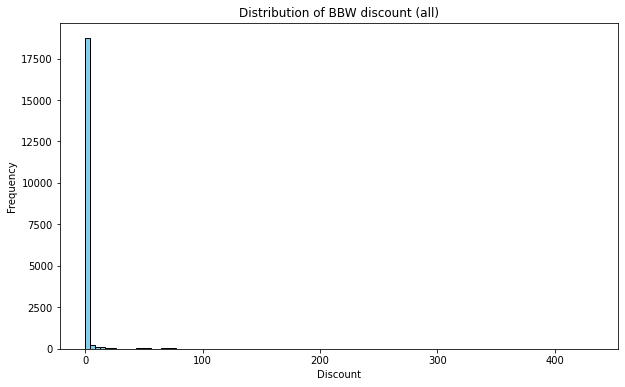

In [44]:
max_discount = to_process['item_discount_raw'].max()
min_discount = to_process['item_discount_raw'].min()
median_discount = to_process['item_discount_raw'].median()

print("Maximum Dicount:", max_discount)
print("Minimum Dicount:", min_discount)
print("Median Dicount:", median_discount)

plt.figure(figsize=(10, 6))
plt.hist(to_process['item_discount_raw'], bins=100, range=(min_discount, max_discount), color='skyblue', edgecolor='black')
plt.title('Distribution of BBW discount (all)')
plt.xlabel('Discount')
plt.ylabel('Frequency')
plt.show()

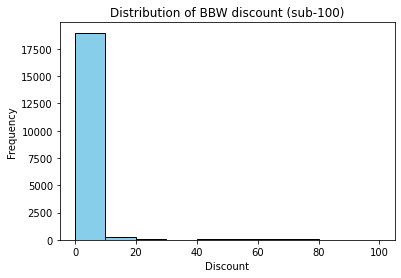

In [45]:
plt.hist(to_process['item_discount_raw'], bins=10, range=(min_discount, 100), color='skyblue', edgecolor='black')
plt.title('Distribution of BBW discount (sub-100)')
plt.xlabel('Discount')
plt.ylabel('Frequency')
plt.show()

### Calculate discount percentage and bin accordingly

In [46]:
def process_disc(item_discount_raw, item_price, item_quantity):
    
    # logic to handle if discount > item price
    if float(item_discount_raw) <= float(item_price) * float(item_quantity):
        total_amt = float(item_price) * float(item_quantity)
        
        if total_amt == 0:
            return np.nan
        
        disc_percentage = (float(item_discount_raw) / total_amt) / float(item_quantity)
        
        return disc_percentage *100
    return np.nan

to_process['item_discount_percentage'] = to_process.apply(lambda x: process_disc(x['item_discount_raw'], x['item_price'], x['item_quantity']), axis=1)

# handle cases where item_price == 0 as they would be NaN
to_process['item_discount_percentage'].fillna(0, inplace=True)

In [47]:
discount_binning = to_process[['customer_id', 'item_discount_percentage']]
discount_binning['item_discount_percentage'].value_counts().sort_values()

# binning ranges
discount_binning['item_disc_bins'] = pd.cut(x=discount_binning['item_discount_percentage'], bins=[-1,0,20,40,60,80,100], labels=['null', 'sub_twenty', 'sub_forty', 'sub_sixty', 'sub_eighty', 'sub_hundred'])
discount_binning['item_disc_bins'].value_counts()

/var/folders/j9/hl0rz3wj6yb5zwjtn6qjs8bh0000gn/T/ipykernel_82362/1350012794.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  discount_binning['item_disc_bins'] = pd.cut(x=discount_binning['item_discount_percentage'], bins=[-1,0,20,40,60,80,100], labels=['null', 'sub_twenty', 'sub_forty', 'sub_sixty', 'sub_eighty', 'sub_hundred'])


item_disc_bins
null           18528
sub_twenty       704
sub_hundred      199
sub_forty         26
sub_eighty         9
sub_sixty          1
Name: count, dtype: int64

### We then one-hot encode this binning

In [82]:
to_process['item_disc_bins'] = pd.cut(x=to_process['item_discount_percentage'], bins=[-1,0,20,40,60,80,100], labels=['null', 'sub_twenty', 'sub_forty', 'sub_sixty', 'sub_eighty', 'sub_hundred'])
to_process1 = to_process.drop(['item_discount_raw', 'item_discount_percentage'], axis=1)
discount_binned = pd.get_dummies(to_process1, columns=['item_disc_bins'])
discount_binned.tail()

,customer_id,order_time,item_quantity,item_id,item_price,sku,item_disc_bins_null,item_disc_bins_sub_twenty,item_disc_bins_sub_forty,item_disc_bins_sub_sixty,item_disc_bins_sub_eighty,item_disc_bins_sub_hundred
19462,9729,2022-02-23 20:23:34 +0800,1,The Prisoner Saldo Zinfandel NV,82.0,NaN,1,0,0,0,0,0
19463,9729,2022-02-23 20:23:34 +0800,1,Louis Tête Coteaux du Lyonnais Antique Bellum ...,34.0,NaN,1,0,0,0,0,0
19464,9729,2022-02-23 20:23:34 +0800,1,Mastrojanni Rosso di Montalcino 2018,77.0,NaN,1,0,0,0,0,0
19465,9729,2022-02-23 20:23:34 +0800,1,Tokumasamune Tokubetsu Junmai Yamahai - 720 ML,82.0,NaN,1,0,0,0,0,0
19466,9729,2022-02-23 20:23:34 +0800,1,Ibaraki Tokumasamune Ginjo Miyamanishiki - 720 ML,78.0,NaN,1,0,0,0,0,0


### Lastly, we separate the date & time, and rearrange the columns

In [83]:
discount_binned['order_date'] = pd.to_datetime(discount_binned['order_time']).dt.date
discount_binned['order_time'] = pd.to_datetime(discount_binned['order_time']).dt.time
# cols = discount_binned.columns.tolist()
# cols

In [84]:
df_final = discount_binned[
    ['customer_id',
     'order_date',
     'order_time',
     'sku',
     'item_id',
     'item_quantity',
     'item_price',
     'item_disc_bins_null',
     'item_disc_bins_sub_twenty',
     'item_disc_bins_sub_forty',
     'item_disc_bins_sub_sixty',
     'item_disc_bins_sub_eighty',
     'item_disc_bins_sub_hundred']
]

In [85]:
df_final.tail()

,customer_id,order_date,order_time,sku,item_id,item_quantity,item_price,item_disc_bins_null,item_disc_bins_sub_twenty,item_disc_bins_sub_forty,item_disc_bins_sub_sixty,item_disc_bins_sub_eighty,item_disc_bins_sub_hundred
19462,9729,2022-02-23,20:23:34,NaN,The Prisoner Saldo Zinfandel NV,1,82.0,1,0,0,0,0,0
19463,9729,2022-02-23,20:23:34,NaN,Louis Tête Coteaux du Lyonnais Antique Bellum ...,1,34.0,1,0,0,0,0,0
19464,9729,2022-02-23,20:23:34,NaN,Mastrojanni Rosso di Montalcino 2018,1,77.0,1,0,0,0,0,0
19465,9729,2022-02-23,20:23:34,NaN,Tokumasamune Tokubetsu Junmai Yamahai - 720 ML,1,82.0,1,0,0,0,0,0
19466,9729,2022-02-23,20:23:34,NaN,Ibaraki Tokumasamune Ginjo Miyamanishiki - 720 ML,1,78.0,1,0,0,0,0,0


In [87]:
df_final.to_csv("../datasets/cleaned_orders.csv", index=False)

# 3. Check Stationarity
- so we can choose a model to use for demand prediction

In [5]:
# read cleaned orders file
df = pd.read_csv('../datasets/cleaned_orders.csv')

# take some sample data
grouped = df[['order_date', 'item_id', 'item_quantity']]
groupedbyitem = grouped.groupby('item_id', group_keys=True).apply(lambda x:x)
groupedbyitem['item_id'].value_counts()

# take a specific item to perform predicion on
sample = groupedbyitem[groupedbyitem['item_id']=='Rara Neagră de Purcari 2020']
sample = sample.groupby('order_date')['item_quantity'].sum().reset_index()
sample['order_date'] = pd.to_datetime(sample['order_date'])
sample = sample.set_index('order_date')

for_tests = pd.DataFrame()
# daily samples
for_tests['qty'] = sample['item_quantity'].resample('D').mean()
for_tests = for_tests.fillna(0)

### Augmented Dickey-Fuller Test
- statistical test called unit root test
- where the unit root is non-stationary
- hypothesis testing
    - H0: Series has a unit root (i.e. Non-stationary)
    - H1: Series does not have a unit root (i.e. Stationary)
- our conditions to reject H0 and say that data is stationary...
    - test statistic < critical value
    - p-value < 0.05

In [7]:
from statsmodels.tsa.stattools import adfuller

test = adfuller(for_tests, autolag='AIC')
output = pd.Series(test[0:4], index=['Test Stat','p-value','# Lags used','# Obsverations used'])

for key, value in test[4].items():
    output['Critical Value (%s)'%key] = value
print(output)

Test Stat               -22.069832
p-value                   0.000000
# Lags used               0.000000
# Obsverations used     462.000000
Critical Value (1%)      -3.444584
Critical Value (5%)      -2.867816
Critical Value (10%)     -2.570113
dtype: float64


- tstat < all critical values
- p-value < 0.05
##### Hence, reject H0. Data is stationary.

### KPSS Test
- unit root test similar to ADF, but cannot be used interchangeably with the ADF test beause the interpretation of p-value is opposite (H0 and H1 are swapped)
- hypothesis testing
    - H0: No unit root (i.e. stationary)
    - H1: Series has a unit root (i.e. non-stationary)
- our conditions to reject H0 and say that data is non-stationary...
    - test statistic < critical value
    - p-value < 0.05

In [9]:
from statsmodels.tsa.stattools import kpss

kpsstest = kpss(for_tests, regression='c', nlags="auto")
kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])

for key,value in kpsstest[3].items():
    kpss_output['Critical Value (%s)'%key] = value
print(kpss_output)

Test Statistic           0.425392
p-value                  0.066210
#Lags Used               7.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


- tstat < critical value at 95% confidence level
- p-value > 0.05
##### Hence, do not reject H0. Data is stationary.

# Our data is stationary, so let's try our 2 Moving Average Models first

# 4. Model #1: ARIMA

In [8]:
# convert to monthly
monthly_sales = pd.DataFrame()
monthly_sales['sales'] = sample['item_quantity'].resample('MS').mean()

We convert to monthly as our predictions will be month by month

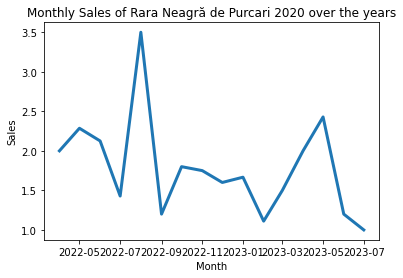

In [11]:
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Sales of Rara Neagră de Purcari 2020 over the years')
plt.plot(monthly_sales.index, monthly_sales.sales, linewidth=3)

# Training Time

In [16]:
x = monthly_sales.index
y = monthly_sales.sales

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 69, shuffle=False)

auto_arima(y_train, test='adf',seasonal=True, stationary = True, trace=True, error_action='ignore', suppress_warnings=True)
auto_arima(y, 
           test='adf',
           seasonal=True,
           stationary=True,
           trace=True,
           error_action='ignore',
           suppress_warnings=True,
           stepwise=True)
model_arima = ARIMA(y_train, order=(1,1,1)).fit()
# model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25.969, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=27.083, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=27.311, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=51.807, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=29.034, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.182 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=33.244, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=34.728, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=34.682, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=67.715, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=36.682, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.200 second

MAPE ARIMA: 33.66%
RMSE ARIMA: 0.6161


<Axes: xlabel='order_date'>

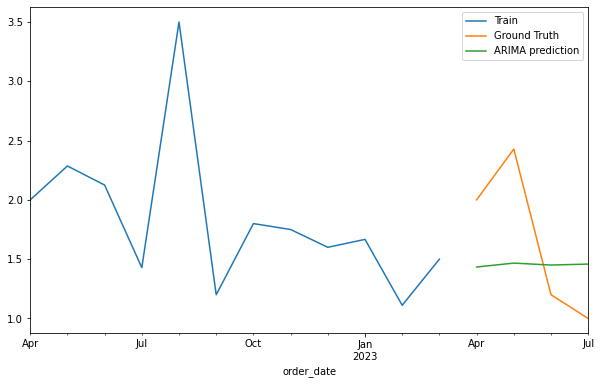

In [29]:
pred_arima = model_arima.predict(start=len(y_train), end=(len(y)-1),dynamic=True)
mape_arima = mean_absolute_percentage_error(y_test, pred_arima) * 100
rmse_arima = mean_squared_error(y_test, pred_arima, squared=False)

print('MAPE ARIMA: %.2f%%' %mape_arima)
print('RMSE ARIMA: %.4f' %rmse_arima)

y_train.plot(legend=True, label='Train', figsize=(10,6))

y_test.plot(legend=True, label= 'Ground Truth')

pred_arima.plot(legend=True, label='ARIMA prediction')

# ARIMA observations:
- ARIMA captures the peaks and troughs
- However, it's very conservative and tends to stick very much to the baseline average
- Let's try SARIMAX, a variant of ARIMA which puts more emphasis on the seasonality of the data

# 5. Model #2: SARIMAX

In [46]:
model_sarimax = sm.tsa.statespace.SARIMAX(y_train,order=(1, 1, 1),seasonal_order=(1,1,1,12))
results_sarimax = model_sarimax.fit()
pred_sarimax = results_sarimax.predict(start= len(y_train), end= (len(y)-1),dynamic=True)
# results_sarimax.summary()

C:\Users\Kevan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Kevan\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE SARIMAX: 62.83%
RMSE SARIMAX: 0.9042


<Axes: xlabel='order_date'>

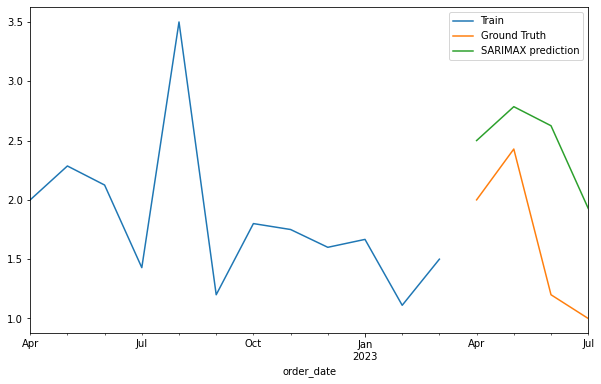

In [47]:
mape_sarimax = mean_absolute_percentage_error(y_test, pred_sarimax) * 100
rmse_sarimax = mean_squared_error(y_test, pred_sarimax, squared=False)

print('MAPE SARIMAX: %.2f%%' %mape_sarimax)
print('RMSE SARIMAX: %.4f' %rmse_sarimax)

y_train.plot(legend=True, label='Train', figsize=(10,6))
y_test.plot(legend=True, label= 'Ground Truth')
pred_sarimax.plot(legend=True, label='SARIMAX prediction')

# SARIMAX Observations:
- From the limited testing data, it's able to capture the seasonality way better than ARIMA
- However, it is worth to note that based on the values alone, we can see that the RMSE is worse for SARIMAX than it is for ARIMA

In [39]:
print('RMSE ARIMA: %.4f' %rmse_arima)
print('RMSE SARIMAX: %.4f' %rmse_sarimax)

RMSE ARIMA: 0.6161
RMSE SARIMAX: 0.9042


Hence, we thought this merits an ensemble learning combining the best of both approaches

# 6. Model #3: Exponential Smoothing
- the gist: model works by assigning exponentially decreasing weights for increasingly past observations (i.e. recent observations are given more weight)

In [10]:
for_model = pd.DataFrame()
# samples daily
for_model['qty'] = sample['item_quantity'].resample('D').mean()
for_model = for_model.fillna(0)

In [11]:
# data is stationary based on our tests
# still, let's see the how the exponential smoothing model performs

# create train & test data
size = len(for_model)
train = for_model.iloc[0:math.ceil(size*0.8)]
test = for_model.iloc[math.ceil(size*0.8)::]

### Simple Exponential Smoothing

In [12]:
ses_results = pd.DataFrame([], columns=['smoothing_level', 'mse', 'mape'])

for x in range(1, 10, 1):
    level = x/10
    ses = SimpleExpSmoothing(train).fit(smoothing_level=level, optimized=False)
    y_pred = ses.forecast(len(test)) # e.g. 3 = 3 months
    temp = [level, round(mean_squared_error(test, y_pred),5), round(mean_absolute_percentage_error(test, y_pred),5)]
    ses_results.loc[len(ses_results)] = temp

ses_results

,smoothing_level,mse,mape
0,0.1,0.81241,8.825207e+14
1,0.2,0.83496,6.267896e+14
2,0.3,0.86662,3.806684e+14
3,0.4,0.89291,2.179194e+14
4,0.5,0.91132,1.171339e+14
5,0.6,0.92349,5.502984e+13
6,0.7,0.93061,2.004263e+13
7,0.8,0.93384,4.512587e+12
8,0.9,0.93472,3.172113e+11


<Axes: xlabel='order_date'>

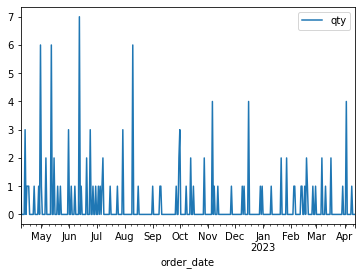

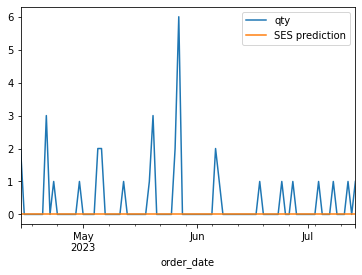

In [23]:
train.plot(legend=True, label='Train')
test.plot(legend=True, label= 'Ground Truth')
y_pred.plot(legend=True, label='SES prediction')

- we see that SES is super bad in predicting demand due to the large number of individual days that have 0 orders
- it doesnt take into account the spikes in orders for certain periods

### Exponential Smoothing w Seasonality

In [17]:
es_results = pd.DataFrame([], columns=['smoothing_seasonal', 'mae', 'mape'])

for x in range(1, 10, 1):
    level = x/10
    es = ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=12).fit(smoothing_seasonal=level)
    y_pred2 = es.forecast(len(test))
    temp = [level, round(mean_squared_error(test, y_pred2),3), round(mean_absolute_percentage_error(test, y_pred2),3)]
    es_results.loc[len(es_results)] = temp

es_results

,smoothing_seasonal,mae,mape
0,0.1,0.885,4.960678e+14
1,0.2,0.911,6.698305e+14
2,0.3,0.956,8.000562e+14
3,0.4,1.028,8.944407e+14
4,0.5,1.130,9.870373e+14
5,0.6,1.264,1.107802e+15
6,0.7,1.428,1.251153e+15
7,0.8,1.622,1.398063e+15
8,0.9,1.846,1.549469e+15


<Axes: xlabel='order_date'>

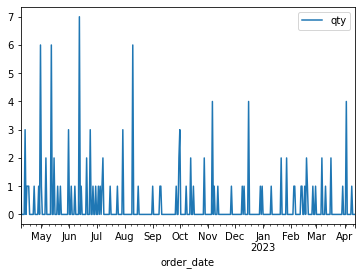

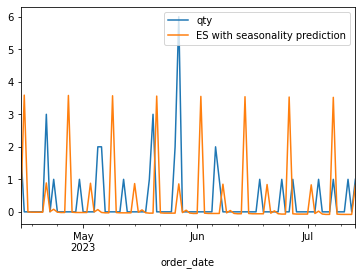

In [21]:
train.plot(legend=True, label='Train')
test.plot(legend=True, label= 'Ground Truth')
y_pred2.plot(legend=True, label='ES with seasonality prediction')

- this is better than simple exponential smoothing but error is still high compared to the ARIMA and SARIMAX models
- may be due to differences in resampling
    - some errors can be offset by resampling by month
- However, we cannot resample by month for exponential smoothing model as it requires at least 2 seasonal cycles
    - "Cannot compute initial seasonals using heuristic method with less than two full seasonal cycles in the data."

## Conclusion
- seems like the stationarity of the data is greatly affecting the quality of demand prediction by exponsntial smoothing model
- let's stick to ARIMA & SARIMAX for ensemble learning

# 7. Model #4: Ensemble Learning of ARIMA and SARIMAX

We first need to find what's the best weight to allocate for each model

In [40]:
# Initialize lists to store MSE and MAPE results
rmse_results = []
mape_results = []

# Iterate through different weight values for pred_arima
for weight in np.arange(0.1, 1.0, 0.1):
    # Calculate the weighted average of the two predictions
    weighted_average = (weight * np.array(pred_arima)) + ((1 - weight) * np.array(pred_sarimax))
    
    # Calculate MSE and MAPE
    rmse = mean_squared_error(y_test, weighted_average, squared=False)
    mape = mean_absolute_percentage_error(y_test, weighted_average)
    
    # Append results to the lists
    rmse_results.append((weight, rmse))
    mape_results.append((weight, mape))

# Print the results
print("ARIMA Weight  SARIMAX Weight  RMSE    MAPE")
for weight, mse in rmse_results:
    mape = next(mape for w, mape in mape_results if w == weight)
    print(f"{weight:.1f}            {(1 - weight):.1f}            {mse:.4f}  {mape*100:.2f}%")


ARIMA Weight  SARIMAX Weight  RMSE    MAPE
0.1            0.9            0.8204  56.52%
0.2            0.8            0.7423  50.20%
0.3            0.7            0.6717  44.69%
0.4            0.6            0.6114  41.09%
0.5            0.5            0.5647  38.32%
0.6            0.4            0.5350  37.39%
0.7            0.3            0.5254  36.45%
0.8            0.2            0.5368  35.52%
0.9            0.1            0.5681  34.59%


# We can see that a 70:30 split between ARIMA:SARIMAX returns the best RMSE, and it is also lower than when we used just ARIMA or just SARIMAX

Let's see how the future sales prediction looks like with this ensemble learning

Text(0.5, 1.0, 'ARIMA:SARIMAX = 70:30 Sales Prediction')

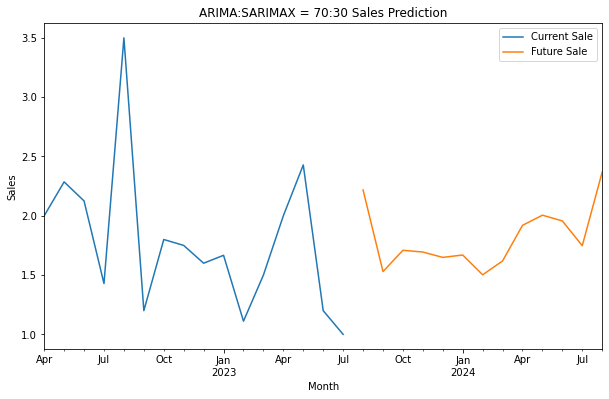

In [43]:
future_sales_arima = model_arima.predict(start=len(y), end=(len(y)+12))
future_sales_sarimax = results_sarimax.predict(start= len(y), end=(len(y)+12))

weight_arima = 0.7
future_sales_weighted = (weight_arima * future_sales_arima) + ((1 - weight_arima) * future_sales_sarimax)

y.plot(legend=True, label='Current Sale', figsize=(10,6))
future_sales_weighted.plot(legend= True, label='Future Sale')
plt.xlabel('Month')  # Replace with your X-axis label
plt.ylabel('Sales')  # Replace with your Y-axis label
plt.title('ARIMA:SARIMAX = 70:30 Sales Prediction')

# Visually, let's compare with if we just used SARIMAX

<Axes: xlabel='order_date'>

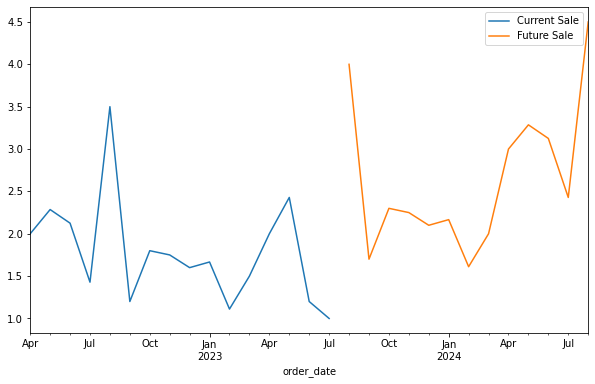

In [49]:
future_sale_sarimax = results_sarimax.predict(start= len(y), end=(len(y)+12))
y.plot(legend=True, label='Current Sale', figsize=(10,6))
future_sale_sarimax.plot(legend= True, label='Future Sale')

- We can see the ensemble learning's predictions are more conservative
- The SARIMAX puts too much importance in seasonality and might be too naive in assuming the upwards trajectory
- Hence, our ensemble learning of ARIMA-SARIMAX gives us a good baseline using classic statistical methods to benchmark against our other planned algorithms which are supposedly more complex